In [11]:
#导入决策树回归器和其它必要的库
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
#生成一个回归任务数据集，样本数量100
X, y  = make_regression(n_samples = 100,
                        #只有一个特征
                       n_features = 1,
                        #为了使线性模型不适用
                        #增加噪音值为60
                       noise = 60,
                        #设定随机状态，便于复现
                       random_state = 18)

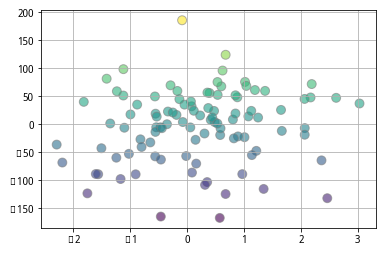

In [13]:
#使用散点图将样本进行可视化
plt.scatter(X, y, s=80,
            #下面几个参数都是为了美观
           c = y, edgecolor = 'grey',
           alpha = 0.6)
#添加网格并展示图像
plt.grid()
plt.show()

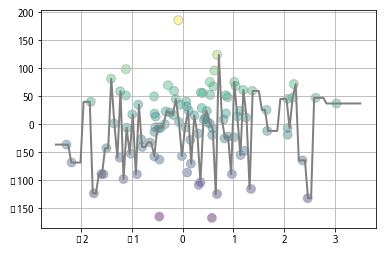

In [14]:
#创建一个决策树示例，可以通过调节max_depth参数来防止模型过拟合
#这里我们不限制决策树的max_depth
reg = DecisionTreeRegressor(max_depth = None)
#使用模型拟合样本数据
reg.fit(X,y)
#为了将模型进行可视化，同样生成一个沿横轴分布的数列
X_new = np.linspace(-2.5, 3.5, 100)
#调用模型对生成数列的目标值作出预测
y_new = reg.predict(X_new.reshape(-1,1))
#以下是绘图的部分
plt.scatter(X, y, s=80,
           c = y, edgecolor = 'grey',
           alpha = 0.4)
plt.plot(X_new, y_new, lw = 2, 
         ls = '-', c='grey')
plt.grid()
plt.show()

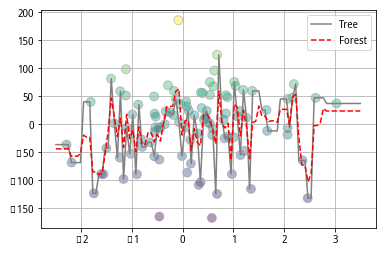

In [15]:
#导入随机森林回归器
from sklearn.ensemble import RandomForestRegressor
#创建一个随机森林实例，指定森林中有100棵决策树
reg2 = RandomForestRegressor(n_estimators=100)
#使用随机森林拟合数据
reg2.fit(X,y)
#同样对生成对数列进行预测
y_new_2 = reg2.predict(X_new.reshape(-1, 1))
#下面是绘图部分
plt.scatter(X, y, s=80,
           c = y, edgecolor = 'grey',
           alpha = 0.4)
#将决策树和随机森林的模型进行可视化
plt.plot(X_new, y_new, lw = 1.5, 
         ls = '-', c='grey',
        label = 'Tree')
plt.plot(X_new, y_new_2, lw = 1.5, 
         ls = '--', c='r',
        label = 'Forest')
#添加图注、网格并展示
plt.legend()
plt.grid()
plt.show()

In [16]:
#查看随机森林中前两棵决策树
reg2.estimators_[:2]

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1702573795, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1335833281, splitter='best')]

In [17]:
#还是先导入jqdata和技术分析工具
import jqdata
from jqlib.technical_analysis import *
#同样选择沪深300成分股做股票池
stocks = get_index_stocks('000300.XSHG')
#创建query对象，指定获取股票的代码、市值、净运营资本
#净债务、产权比率、股东权益比率、营收增长率、换手率、
#市盈率（PE）、市净率（PB）、市销率（PS）、总资产收益率因子
q = query(valuation.code, valuation.market_cap,
           balance.total_current_assets- balance.total_current_liability,
        balance.total_liability- balance.total_assets,
           balance.total_liability/balance.equities_parent_company_owners,
        (balance.total_assets-balance.total_current_assets)/balance.total_assets,
        balance.equities_parent_company_owners/balance.total_assets,
        indicator.inc_total_revenue_year_on_year,
           valuation.turnover_ratio,
        valuation.pe_ratio,
           valuation.pb_ratio,
           valuation.ps_ratio,indicator.roa).filter(
     valuation.code.in_(stocks))
#将获得的因子值存入一个数据表
df = get_fundamentals(q, date = None)
#把数据表的字段名指定为对应的因子名
df.columns = ['code', '市值', '净营运资本', 
              '净债务', '产权比率','非流动资产比率',
              '股东权益比率', '营收增长率'
          ,'换手率','PE','PB','PS','总资产收益率']
#检查结果
df.head()

,code,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率
0,000001.XSHE,2592.6306,NaN,-3.523551e+11,10.727655,NaN,0.085269,16.78,0.3094,8.8495,0.9180,1.8079,0.21
1,000002.XSHE,2953.2500,1.844060e+11,-2.741111e+11,7.768757,0.166689,0.108440,-1.24,0.7007,7.5723,1.5654,0.8041,0.14
2,000063.XSHE,1864.7742,2.909473e+10,-4.400492e+10,2.463276,0.264459,0.283314,-3.23,1.8145,36.8150,4.5189,2.0715,0.56
3,000069.XSHE,497.8921,1.063939e+11,-9.615190e+10,4.539212,0.203262,0.167787,-13.91,0.4601,4.1559,0.7357,0.8450,0.20
4,000100.XSHE,688.5975,1.294600e+10,-6.585340e+10,3.517485,0.686085,0.175928,-53.49,3.0147,30.6479,2.3668,1.1628,0.16


In [18]:
#将股票代码作为数据表的index
df.index = df.code.values
#使用del也可以删除列
del df['code']
#下面来把时间变量都定义好
today = datetime.datetime.today()
#设定3个时间差，分别是50天，1天和2天
delta50 = datetime.timedelta(days=50)
delta1 = datetime.timedelta(days=1)
delta2 = datetime.timedelta(days=2)
#50日前作为一个历史节点
history = today - delta50
#再计算昨天和2天前的日期
yesterday = today - delta1
two_days_ago = today - delta2
#下面就获取股票的动量线、成交量、累计能量线、平均差、
#指数移动平均、移动平均、乖离率等因子
#时间范围都设为10天
df['动量线']=list(MTM(df.index, two_days_ago, 
                   timeperiod=10, unit = '1d', 
                   include_now = True, 
                   fq_ref_date = None).values())
df['成交量']=list(VOL(df.index, two_days_ago, M1=10 ,
                   unit = '1d', include_now = True, 
                   fq_ref_date = None)[0].values())
df['累计能量线']=list(OBV(df.index,check_date=two_days_ago, 
                     timeperiod=10).values())
df['平均差']=list(DMA(df.index, two_days_ago, N1 = 10, 
                   unit = '1d', include_now = True, 
                   fq_ref_date = None)[0].values())
df['指数移动平均']=list(EMA(df.index, two_days_ago, timeperiod=10, 
                      unit = '1d', include_now = True, 
                      fq_ref_date = None).values())
df['移动平均']=list(MA(df.index, two_days_ago, timeperiod=10, 
                   unit = '1d', include_now = True, 
                   fq_ref_date = None).values())
df['乖离率']=list(BIAS(df.index,two_days_ago, N1=10, 
                    unit = '1d', include_now = True, 
                    fq_ref_date = None)[0].values())
#把数据表中的空值用0来代替
df.fillna(0,inplace=True)
#检查是否成功
df.head()

,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率,动量线,成交量,累计能量线,平均差,指数移动平均,移动平均,乖离率
000001.XSHE,2592.6306,0.000000e+00,-3.523551e+11,10.727655,0.000000,0.085269,16.78,0.3094,8.8495,0.9180,1.8079,0.21,-0.82,637208.57,-2.842108e+08,0.2564,13.488896,13.649,-3.289618
000002.XSHE,2953.2500,1.844060e+11,-2.741111e+11,7.768757,0.166689,0.108440,-1.24,0.7007,7.5723,1.5654,0.8041,0.14,-0.65,1385652.94,8.130130e+07,-1.0004,26.009862,26.075,0.517737
000063.XSHE,1864.7742,2.909473e+10,-4.400492e+10,2.463276,0.264459,0.283314,-3.23,1.8145,36.8150,4.5189,2.0715,0.56,1.47,849834.93,3.749767e+08,-1.1888,41.127054,41.679,-3.524557
000069.XSHE,497.8921,1.063939e+11,-9.615190e+10,4.539212,0.203262,0.167787,-13.91,0.4601,4.1559,0.7357,0.8450,0.20,-0.32,330645.76,-8.019955e+07,-0.0854,6.237611,6.290,-2.861685
000100.XSHE,688.5975,1.294600e+10,-6.585340e+10,3.517485,0.686085,0.175928,-53.49,3.0147,30.6479,2.3668,1.1628,0.16,0.68,5612078.99,2.722158e+09,0.1166,4.828376,4.853,0.968473


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 000001.XSHE to 603993.XSHG
Data columns (total 19 columns):
市值         300 non-null float64
净营运资本      300 non-null float64
净债务        300 non-null float64
产权比率       300 non-null float64
非流动资产比率    300 non-null float64
股东权益比率     300 non-null float64
营收增长率      300 non-null float64
换手率        300 non-null float64
PE         300 non-null float64
PB         300 non-null float64
PS         300 non-null float64
总资产收益率     300 non-null float64
动量线        300 non-null float64
成交量        300 non-null float64
累计能量线      300 non-null float64
平均差        300 non-null float64
指数移动平均     300 non-null float64
移动平均       300 non-null float64
乖离率        300 non-null float64
dtypes: float64(19)
memory usage: 46.9+ KB


In [20]:
#获取股票前一日的收盘价
df['close1']=list(get_price(stocks, 
                       end_date=yesterday, 
                       count = 1,
                       fq='pre',panel=False)['close'])
#获取股票50日前的收盘价
df['close2']=list(get_price(stocks,  
                       end_date=history, 
                       count = 1,
                       fq ='pre',panel=False)['close'])

#计算出收益
df['return']=df['close1']/df['close2']-1
#如果收益大于平均水平，则标记为1
#否则标记为0
df['signal']=np.where(df['return']<df['return'].mean(),0,1)
#检查是否成功
df.head()

,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率,动量线,成交量,累计能量线,平均差,指数移动平均,移动平均,乖离率,close1,close2,return,signal
000001.XSHE,2592.6306,0.000000e+00,-3.523551e+11,10.727655,0.000000,0.085269,16.78,0.3094,8.8495,0.9180,1.8079,0.21,-0.82,637208.57,-2.842108e+08,0.2564,13.488896,13.649,-3.289618,13.36,12.80,0.043750,0
000002.XSHE,2953.2500,1.844060e+11,-2.741111e+11,7.768757,0.166689,0.108440,-1.24,0.7007,7.5723,1.5654,0.8041,0.14,-0.65,1385652.94,8.130130e+07,-1.0004,26.009862,26.075,0.517737,26.13,25.65,0.018713,0
000063.XSHE,1864.7742,2.909473e+10,-4.400492e+10,2.463276,0.264459,0.283314,-3.23,1.8145,36.8150,4.5189,2.0715,0.56,1.47,849834.93,3.749767e+08,-1.1888,41.127054,41.679,-3.524557,40.43,42.80,-0.055374,0
000069.XSHE,497.8921,1.063939e+11,-9.615190e+10,4.539212,0.203262,0.167787,-13.91,0.4601,4.1559,0.7357,0.8450,0.20,-0.32,330645.76,-8.019955e+07,-0.0854,6.237611,6.290,-2.861685,6.07,6.39,-0.050078,0
000100.XSHE,688.5975,1.294600e+10,-6.585340e+10,3.517485,0.686085,0.175928,-53.49,3.0147,30.6479,2.3668,1.1628,0.16,0.68,5612078.99,2.722158e+09,0.1166,4.828376,4.853,0.968473,5.09,4.04,0.259901,1


In [21]:
#导入数据集拆分工具
from sklearn.model_selection import train_test_split
#导入决策树分类器
from sklearn.tree import DecisionTreeClassifier
#把因子值作为样本的特征，所以要去掉刚刚添加的几个字段
X = df.drop(['close1', 'close2', 'return', 'signal'], axis = 1)
#把signal作为分类标签
y = df['signal']
#将数据拆分为训练集和验证集
X_train,X_test,y_train,y_test=\
train_test_split(X,y,test_size = 0.2)
#创建决策树分类器实例，指定random_state便于复现
clf = DecisionTreeClassifier(random_state=1000)
#拟合训练集数据
clf.fit(X_train, y_train)
#查看分类器在训练集和验证集中的准确率
print(clf.score(X_train, y_train),
      clf.score(X_test, y_test))

1.0 0.8833333333333333


In [22]:
#为了便于观察，我们创建一个数据表
#数据表有两个字段，分别是特征名和重要性
#特征名就是因子的名称
#重要性就是决策树给出的feature_importances_
factor_weight = pd.DataFrame({'features':list(X.columns),
                             'importance':clf.feature_importances_}).sort_values(
    #这里根据重要程度降序排列，一遍遍找到重要性最高的特征
    by='importance', ascending = False)
#检查结果
factor_weight

,features,importance
15,平均差,0.646513
7,换手率,0.070865
17,移动平均,0.068328
18,乖离率,0.058971
12,动量线,0.040583
10,PS,0.036857
8,PE,0.030361
3,产权比率,0.017333
4,非流动资产比率,0.016527
9,PB,0.013662


In [76]:
stocks = get_index_stocks('000300.XSHG')
q = query(valuation.code,valuation.market_cap).filter(
     valuation.code.in_(stocks))
dataset = get_fundamentals(q)
dataset['平均差'] = list(DMA(dataset.code, yesterday)[0].values())
dataset['换手率'] = list(HSL(dataset.code, yesterday)[0].values())
dataset['移动平均'] = list(MA(dataset.code, yesterday).values())
dataset['乖离率'] = list(BIAS(dataset.code, yesterday)[0].values())
dataset['动量线'] = list(MTM(dataset.code,yesterday).values())
dataset.head()

,code,market_cap,平均差,换手率,移动平均,乖离率,动量线
0,000001.XSHE,2592.6306,0.2260,0.309377,13.344,-0.434729,-0.16
1,000002.XSHE,2953.2500,-0.9448,0.700746,25.850,1.031061,-0.26
2,000063.XSHE,1864.7742,-1.0362,1.814512,40.850,-1.578285,1.27
3,000069.XSHE,497.8921,-0.1118,0.460079,6.118,-1.193706,-0.27
4,000100.XSHE,688.5975,0.1810,3.014727,5.012,2.174640,0.96


In [77]:
dataset.index = dataset.code
dataset.drop('code', axis = 1, inplace = True)
dataset.head()

,market_cap,平均差,换手率,移动平均,乖离率,动量线
code,,,,,,
000001.XSHE,2592.6306,0.2260,0.309377,13.344,-0.434729,-0.16
000002.XSHE,2953.2500,-0.9448,0.700746,25.850,1.031061,-0.26
000063.XSHE,1864.7742,-1.0362,1.814512,40.850,-1.578285,1.27
000069.XSHE,497.8921,-0.1118,0.460079,6.118,-1.193706,-0.27
000100.XSHE,688.5975,0.1810,3.014727,5.012,2.174640,0.96


In [123]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(random_state=20)
X = dataset.drop('market_cap', axis = 1)
y = dataset['market_cap']
reg.fit(X,y)

predict = pd.DataFrame(reg.predict(X), 
                       #保持和y相同的index，也就是股票的代码
                       index = y.index,
                       #设置一个列名，这个根据你个人爱好就好
                       columns = ['predict_mcap'])
#使用真实的市值，减去模型预测的市值
diff = dataset['market_cap'] - predict['predict_mcap']
#将两者的差存入一个数据表，index还是用股票的代码
diff = pd.DataFrame(diff, index = y.index, columns = ['diff'])
#将该数据表中的值，按生序进行排列
diff = diff.sort_values(by = 'diff', ascending = True)
#找到市值被低估最多的10只股票
diff.diff

<bound method DataFrame.diff of                    diff
code                   
601998.XSHG -6743.53911
600968.XSHG -3149.42738
603833.XSHG -2858.38202
600663.XSHG -2258.94802
600000.XSHG -2235.79370
601992.XSHG -2032.64267
600115.XSHG -1699.12878
002032.XSHE -1365.23881
600015.XSHG -1068.38311
600585.XSHG -1068.18241
601898.XSHG -1060.43507
600436.XSHG -1030.46277
002736.XSHE  -972.30599
603899.XSHG  -905.49248
600998.XSHG  -882.02491
001979.XSHE  -806.10598
601985.XSHG  -724.33571
600023.XSHG  -719.61644
002460.XSHE  -653.74616
601877.XSHG  -650.91736
600170.XSHG  -647.68919
600177.XSHG  -621.18869
000709.XSHE  -576.88027
002624.XSHE  -567.54075
601988.XSHG  -514.08165
300033.XSHE  -509.92949
000898.XSHE  -509.12420
600196.XSHG  -502.22106
002271.XSHE  -495.63015
000630.XSHE  -488.01257
...                 ...
600309.XSHG   400.34167
601066.XSHG   401.92853
601688.XSHG   428.74588
000001.XSHE   428.89061
600030.XSHG   432.66154
000002.XSHE   432.81218
601328.XSHG   438.87227
600837.X

In [99]:
reg.score(X,y)

0.8491654570977536